In [1]:
import numpy as np
import pandas as pd


from NPIR import NPIR

from sklearn.utils import shuffle
from sklearn import datasets
from sklearn.datasets import make_blobs
from sklearn import metrics

import matplotlib.pyplot as plt

import datetime
import warnings
from collections import Counter as Cs
from timeit import default_timer as timer
from datetime import timedelta


import findspark
findspark.init()

########
from numpy import array
from math import sqrt
from pyspark.mllib.clustering import KMeans, KMeansModel
########

from pyspark import SparkContext
from operator import *
from pyspark import StorageLevel
from pyspark.sql.types import IntegerType, FloatType, BooleanType, StringType, StructType,\
StructField,ArrayType, DataType
from pyspark.sql.functions import udf, log, rand, monotonically_increasing_id, col, broadcast,\
greatest, desc, asc, row_number, avg, mean, least, struct, lit, sequence, sum, concat
from functools import reduce
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, SQLContext, Window, Row, DataFrame
from pyspark import SparkConf

In [2]:
spark = SparkSession.builder.master("local[*]").config("spark.sql.broadcastTimeout", "30000s").\
config("spark.network.timeout","30000s").config("spark.executor.heartbeatInterval","12000000ms").\
config("spark.storage.blockManagerSlaveTimeoutMs","12000001ms").config("spark.driver.maxResultSize","12g").\
config("spark.default.parallelism", "100").config("spark.memory.offHeap.enabled","true").\
config("spark.memory.offHeap.size", "25g").appName("NPIR_Parallel").getOrCreate()

In [3]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [4]:
x1,y1 = make_blobs(n_samples=1000, centers=3, n_features=3,
                random_state=1)
data = pd.DataFrame(x1)
data['label'] = y1
data.head()

,0,1,2,label
0,-1.785319,5.568516,-10.649756,0
1,-2.565005,4.564475,-9.979172,0
2,-4.497358,-5.706487,-8.941820,1
3,-1.507116,4.077689,-11.093956,0
4,-5.918326,-1.266070,-1.457767,2


In [5]:
data = shuffle(data)
data.head()

,0,1,2,label
942,-5.984124,-3.697171,-0.886644,2
493,-3.928914,-8.867951,-8.966655,1
533,-6.409158,-0.437017,-2.710381,2
112,-1.778669,2.198126,-10.234328,0
312,-3.700524,-7.186309,-6.288714,1


In [6]:
data.to_csv('blobs3.csv', index=False)

In [7]:
#read csv
data_spark_df = spark.read.format('csv').option('header','True').option('index','False').load('blobs3.csv')
# data_spark_df.show()

In [8]:
data_spark_df = data_spark_df.select(data_spark_df.columns[:-1])

In [9]:
# data_spark_df

In [10]:
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)
spark.conf.set('spark.jars.packages','com.databricks:spark-cav_2.11')
spark.conf.set("spark.sql.parquet.compression.codec","gzip")
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "False")
sqlContext.setConf("spark.sql.shuffle.partitions", "100")

In [11]:
points = data_spark_df.count()
points

1000

In [12]:
#IR: The indexing ratio to be used for generating the maximum index
IR = 0.2
#The number of iteration i
i = 10
k = 3 #k: Number of clusters
# count = Cs()
chunk = 250

In [13]:
from pyspark.sql.functions import desc, row_number, monotonically_increasing_id
from pyspark.sql.window import Window

data_spark = data_spark_df.withColumn('index_column_name', row_number().\
                                          over(Window.orderBy(monotonically_increasing_id())) - 1)
# data_spark.show()

In [14]:
def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)

In [15]:
# data_spark.columns

In [16]:
leaderheadr = ['chunkLabel', 'old label'
               #, 'count'
              ]
leaderheadr.extend([str(x) for x in range(1, len(data_spark.columns))])
leaderheadr = tuple(leaderheadr)
leaderheadr

('chunkLabel', 'old label', '1', '2', '3')

In [17]:
labelsheader = ('chunkLabel', 'label')
labelsheader

('chunkLabel', 'label')

In [18]:
start = timer()


labels = sqlContext.createDataFrame([np.full(len(labelsheader), np.nan).tolist()],labelsheader)
labels = labels.na.drop()

leaders = sqlContext.createDataFrame([np.full(len(leaderheadr), np.nan).tolist()],leaderheadr)
leaders = leaders.na.drop()

ii = 0
for z in range(0, points, chunk):
    j = z + chunk
    data = data_spark.where(col("index_column_name").between(z, j-1)).toPandas()
    data.drop("index_column_name",axis=1,inplace=True)
    data = data.astype(float)
    from NPIR import NPIR
    label = NPIR(data.values,k,IR,i)
    data['labels'] = label
    
    # Adding to pyspard label
    chunklabel = np.full(len(label), ii).tolist()
    labelDF = [(x, y) for x, y in zip(chunklabel, label)]
    labelsDF = sqlContext.createDataFrame(labelDF,labelsheader)
    labels = unionAll(labels, labelsDF)

    leader = []
    f = list(Cs(label))
    f.sort()
    for i in f:
        leader.append([round(np.mean(z), 4) for z in data[data['labels']==i].values[:,:-1].T])
    del data
    del NPIR
    
    # Adding to pyspark leaders
    for x in range(len(leader)):
        x1 = [ii, x]
        x1.extend(leader[x])
        leader[x] = x1
    leaderDF = sqlContext.createDataFrame(leader,leaderheadr)
    leaders = unionAll(leaders, leaderDF)
    ii += 1


In [19]:
# # Load and parse the data
# data = sc.textFile("data/mllib/kmeans_data.txt")
# parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))
parsedData = leaders.select(leaders.columns[2:]).rdd.map(list)

# start = timer()
# Build the model (cluster the data)
clusters = KMeans.train(parsedData, k, maxIterations=20, initializationMode="random")
# end = timer()
# print ("Execution time HH:MM:SS:", timedelta(seconds = end - start))

In [20]:
def squaree1(c,u,f,g):
    c = float(c)
    u = float(u)
    f = float(f)
    g = float(g)
    array1 = np.array([c,u])
    array2 = np.array([f,g])
    dist = np.linalg.norm(array1-array2)
    dist = dist.item()
    return dist

squaree_spark1 = udf(lambda x,y,z,r: squaree1(x,y,z,r), FloatType())
sqlContext.sql("SET spark.sql.autoBroadcastJoinThreshold = -1")

DataFrame[key: string, value: string]

In [21]:
# start = timer()
leaderlabe = sqlContext.createDataFrame(clusters.predict(parsedData).map(lambda x: (x, )),\
            ['defined_cluster']).withColumn('index1', row_number().\
            over(Window.orderBy(monotonically_increasing_id())) - 1)
# leaderlabe.show()


In [22]:
spark_cluster_centroid = parsedData.toDF().withColumn('index', row_number().\
                                          over(Window.orderBy(monotonically_increasing_id())) - 1)
# spark_cluster_centroid.show()

In [23]:
spark_cluster_centroid = (spark_cluster_centroid
    .join(leaderlabe, (col('index') == col('index1')), "left")).\
drop('index').drop('index1')
# spark_cluster_centroid.show()

In [24]:
final_data = spark_cluster_centroid.withColumn('index', row_number().\
                                          over(Window.orderBy(monotonically_increasing_id())) - 1)
# final_data.show()

In [25]:
leaders1 = leaders.withColumnRenamed('old label', 'old_label')
leaders1.registerTempTable("leaders1")
leaders1 = sqlContext.sql("SELECT CONCAT(chunkLabel, old_label) as chunkOldLabel FROM leaders1")
# leaders1.show()

In [26]:
leaders1 = leaders1.withColumn('index_column_name', row_number().\
                    over(Window.orderBy(monotonically_increasing_id())) - 1)
# leaders1.show()

In [27]:
lead_final = (final_data
    .join(leaders1, (col('index')) == col('index_column_name'), "left")).\
drop('index_column_name').drop('index')
#     .withColumnRenamed("defined_cluster", "new label"))
# lead_final.show()

In [28]:
for c in final_data.columns[:-2]:
    lead_final = lead_final.drop(c)
# lead_final.show()

In [29]:
# labels = labels.withColumnRenamed('label', 'old_label')
labels.registerTempTable("labels")
# labels.show()

In [30]:
labels1 = sqlContext.sql("SELECT CONCAT(chunkLabel, label) as chunkLabel FROM labels")
# labels1.show()

In [31]:
lead_final = (final_data
    .join(leaders1, (col('index')) == col('index_column_name'), "left")).\
drop('index_column_name').drop('index').drop('_1').drop('_2').drop('_3')

In [32]:
labels1 = labels1.withColumn('index', row_number().\
                    over(Window.orderBy(monotonically_increasing_id())) - 1)

In [33]:
label_lead_final = (labels1.join(lead_final, (col('chunkLabel') == col('chunkOldLabel')),"left"))
# drop('chunkLabel').drop('chunkOldLabel')

# label_lead_final.show()

In [34]:
label_lead_final = label_lead_final.orderBy('index',ascending=True)
# label_lead_final.show()

In [35]:
d = label_lead_final.toPandas()
end = timer()
print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))
# d

Execution time HH:MM:SS: 0:01:30.292368


In [36]:
# Cs(d['defined_cluster'])

In [37]:
data = pd.read_csv('blobs3.csv')
data.head()

,0,1,2,label
0,-5.984124,-3.697171,-0.886644,2
1,-3.928914,-8.867951,-8.966655,1
2,-6.409158,-0.437017,-2.710381,2
3,-1.778669,2.198126,-10.234328,0
4,-3.700524,-7.186309,-6.288714,1


In [38]:
data = data[['0','1','2', 'label']]


In [39]:
data['new'] = d['defined_cluster'].astype('int8')
# data['new'] = NPIR(pd.read_csv('blobs.csv', header=None).iloc[:,:2].values,k,IR,i)
data.head()

,0,1,2,label,new
0,-5.984124,-3.697171,-0.886644,2,1
1,-3.928914,-8.867951,-8.966655,1,1
2,-6.409158,-0.437017,-2.710381,2,1
3,-1.778669,2.198126,-10.234328,0,2
4,-3.700524,-7.186309,-6.288714,1,1


In [40]:
y = data['label']
labelsPred = data['new']
# list(labelsPred)

In [41]:
x = data[['0','1', '2']].values
x.shape

(1000, 3)

In [42]:
#printing results
print('labels:')
# print(labelsPred)

# tEnd = datetime.datetime.now()
# print('Time: ' + str(tEnd - tStart))
print('Measures:')
print('HS: ' + str(metrics.homogeneity_score(y,labelsPred)))
print('CS: ' + str(metrics.completeness_score(y,labelsPred)))
print('VM: ' + str(metrics.v_measure_score(y,labelsPred)))
print('AMI: ' + str(metrics.adjusted_mutual_info_score(y,labelsPred)))
print('ARI: ' + str(metrics.adjusted_rand_score(y,labelsPred)))


labels:
Measures:
HS: 0.579800401766555
CS: 0.7770949950943455
VM: 0.6641042359032616
AMI: 0.6633982753870096
ARI: 0.4803260205648344


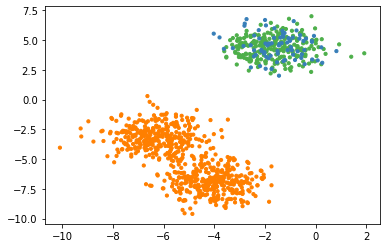

In [43]:
import matplotlib.pyplot as plt
from itertools import cycle, islice 

fig = plt.figure()      
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3',
                                    '#999999', '#e41a1c', '#dede00']),int(k))))
plt.scatter(x[:, 0], x[:, 1], s=10, color=colors[labelsPred.tolist()])
plt.show()
# plt.clf()
